In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [3]:
from project_fraud.lib import drop_many_missing_values


In [4]:
data = drop_many_missing_values()


# Convert mail column

In [5]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

for c in ['P_emaildomain']:
    data[c + '_bin'] = data[c].map(emails)
    data[c + '_suffix'] = data[c].map(lambda x: str(x).split('.')[-1])
    

  

# New feature: day of the week

In [6]:
# create new feature day of the week, encoded as 0-6 
# found a good offset is 0.58

def make_day_feature(data, offset=0, column_name='TransactionDT'):

    days = data[column_name] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

# New feature: hour of the day

In [7]:
# create new feature hour of the day, encoded as 0-23

def make_hour_feature(data, column_name='TransactionDT'):

    hours = data[column_name] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

(0.0, 1000.0)

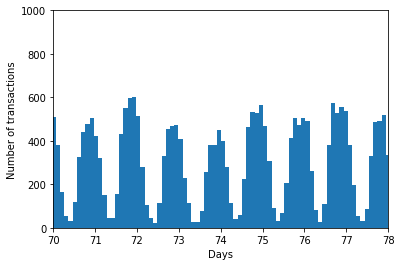

In [8]:
# visualize periodicity: number of transactions per time interval 

vals = plt.hist(data['TransactionDT'] / (3600*24), bins=1800)
plt.xlim(70, 78)
plt.xlabel('Days')
plt.ylabel('Number of transactions')
plt.ylim(0,1000)

# Create new features: weekday and hour of day

Text(0, 0.5, 'Fraction of fraudulent transactions')

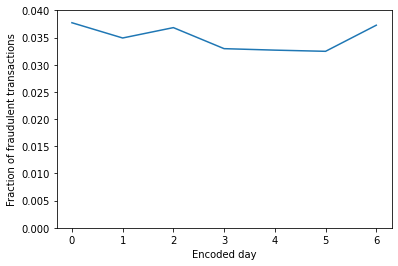

In [9]:
# create new feature weekday
# offset to define start of the day: 0.85

data['weekday'] = make_day_feature(data, offset=0.58)

plt.plot(data.groupby('weekday').mean()['isFraud'])

plt.ylim(0, 0.04)
plt.xlabel('Encoded day')
plt.ylabel('Fraction of fraudulent transactions')

# outputs fraction of fraudulent transactions per weekday

Text(0, 0.5, 'Number of transactions')

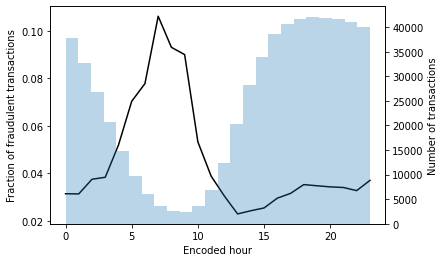

In [10]:
# create a feature which encodes the (relative) hour of the day

data['hours'] = make_hour_feature(data)

plt.plot(data.groupby('hours').mean()['isFraud'], color='k')

ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(data['hours'], alpha=0.3, bins=24)
ax.set_xlabel('Encoded hour')
ax.set_ylabel('Fraction of fraudulent transactions')

ax2.set_ylabel('Number of transactions')

# New features on each credit card

In [11]:
def function(row):
    if pd.isna(row['card1']):
        return np.nan
    elif pd.isna(row['card2']):
        return np.nan
    elif pd.isna(row['card3']):
        return np.nan
    elif pd.isna(row['card4']):
        return np.nan
    elif pd.isna(row['card5']):
        return np.nan
    elif pd.isna(row['card6']):
        return np.nan
    else: 
        return str(row['card1']) + str(row['card2']) + str(row['card3']) + str(row['card4']) + str(row['card5']) + str(row['card6'])

In [12]:
data['cardID'] = data.apply(lambda row: function(row), axis=1)


In [14]:
credit_cards = data.groupby('cardID').agg(
    mean = pd.NamedAgg(column='TransactionAmt', aggfunc='mean'), 
    min = pd.NamedAgg(column='TransactionAmt', aggfunc='min'), 
    max = pd.NamedAgg(column='TransactionAmt', aggfunc='max'),
    median = pd.NamedAgg(column='TransactionAmt', aggfunc='median'),
)

AttributeError: module 'pandas' has no attribute 'NamedAgg'

In [ ]:
data = data.merge(credit_cards, how='left', on="cardID")


# Create new features:
- Distance of current transaction from mean of transaction from credit card
- Distance of current transaction from median of transaction from credit card
- Relative distance of current transaction from mean of transaction from credit card
- Relative distance of current transaction from median of transaction from credit card

In [14]:
def dist_from_mean(row, metric): 
    if pd.isna(row['TransactionAmt']):
        return np.nan
    if pd.isna(row[metric]):
        return np.nan
    else: 
        dist = row['TransactionAmt'] - row[metric]
        return dist

In [15]:
data['dist_mean'] = data.apply(lambda row: dist_from_mean(row, 'mean'), axis=1)
data['dist_median'] = data.apply(lambda row: dist_from_mean(row, 'median'), axis=1)

In [16]:
def dist_from_median_rel(row, metric): 
    if pd.isna(row['TransactionAmt']):
        return np.nan
    if pd.isna(row[metric]):
        return np.nan
    else: 
        dist_rel = (row['TransactionAmt'] - row[metric]) / row[metric]
        return dist_rel

In [17]:
data['dist_mean_rel'] = data.apply(lambda row: dist_from_median_rel(row, 'mean'), axis=1)

In [18]:
data['dist_median_rel'] = data.apply(lambda row: dist_from_median_rel(row, 'median'), axis=1)

In [24]:
data.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,hours,cardID,mean,min,max,median,dist_mean,dist_median,dist_mean_rel,dist_median_rel
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,0.0,2755404.0150.0mastercard102.0credit,235.020796,10.000,6085.230,115.0000,-206.020796,-86.0000,-0.876607,-0.747826
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,0.0,4663490.0150.0visa166.0debit,96.791005,12.500,994.000,59.0000,-37.791005,0.0000,-0.390439,0.000000
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,0.0,18132567.0150.0mastercard117.0debit,123.308485,6.000,3190.000,59.9500,-73.308485,-9.9500,-0.594513,-0.165972
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,0.0,4497514.0150.0mastercard102.0credit,96.972222,20.950,200.000,108.9500,-46.972222,-58.9500,-0.484388,-0.541074
5,2987005,0,86510,49.000,W,5937,555.0,150.0,visa,226.0,...,0.0,5937555.0150.0visa226.0debit,134.071429,49.000,317.500,117.0000,-85.071429,-68.0000,-0.634523,-0.581197
6,2987006,0,86522,159.000,W,12308,360.0,150.0,visa,166.0,...,0.0,12308360.0150.0visa166.0debit,102.088252,12.500,2161.000,59.0000,56.911748,100.0000,0.557476,1.694915
7,2987007,0,86529,422.500,W,12695,490.0,150.0,visa,226.0,...,0.0,12695490.0150.0visa226.0debit,141.113203,7.970,4437.950,83.9500,281.386797,338.5500,1.994050,4.032758
8,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,0.0,2803100.0150.0visa226.0debit,142.466391,4.970,3511.950,77.0000,-127.466391,-62.0000,-0.894712,-0.805195
9,2987009,0,86536,117.000,W,17399,111.0,150.0,mastercard,224.0,...,0.0,17399111.0150.0mastercard224.0debit,121.864231,4.795,2775.000,60.4750,-4.864231,56.5250,-0.039915,0.934684


# IMPORT 

In [20]:
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

# IMPUTER AND ENCODING 

In [21]:
X = data[['TransactionID','P_emaildomain_suffix','P_emaildomain_bin',
'card1','card2','addr1','TransactionAmt','card5','D15','C13','D2','D10','D4','TransactionDT','weekday','hours','cardID',\
          'mean','max','median','min', 'dist_mean', 'dist_median','dist_mean_rel','dist_median_rel']]
y = data['isFraud']

In [22]:
n = (X.dtypes != 'object')
num_cols = list(n[n].index)
medium_missing_num_cols = []
low_missing_num_cols =[]
for i in num_cols:
    percentage = data[i].isnull().sum() * 100 / len(data[i])
    if percentage < 15:
        low_missing_num_cols.append(i)
    elif percentage >= 15 and percentage <= 60:
        medium_missing_num_cols.append(i)

In [23]:
num_transformer_low = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
num_transformer_medium = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#cat_transformer = Pipeline([
    #'imputer', SimpleImputer(strategy='constant', fill_value = "Unknown")
    #])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('one_hot', OneHotEncoder())
])
    
preprocessor = ColumnTransformer([
    ('low_num_imputer',num_transformer_low, low_missing_num_cols),
    ('medium_num_imputer', num_transformer_medium, medium_missing_num_cols),
    ('cat_transformer', cat_pipeline, ['P_emaildomain_suffix','P_emaildomain_bin','weekday','hours'])],
    remainder='passthrough')

pd.DataFrame(preprocessor.fit_transform(X)).head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,-1.73205,0.821695,-3.62996e-16,0.253,-0.278167,-1.3938,-0.243806,-0.65109,-1.57799,-1.4582,...,0,0,0,0,0,0,0,0,0,NaN
1,-1.73204,-1.45756,0.26466,0.35726,-0.443327,-2.36715,-0.243806,-0.727356,-1.57799,-1.4582,...,0,0,0,0,0,0,0,0,0,2755404.0150.0mastercard102.0credit
2,-1.73204,-1.06826,0.813847,0.40939,-0.317889,-0.809796,-0.243806,-0.727356,-1.57797,-1.4582,...,0,0,0,0,0,0,0,0,0,4663490.0150.0visa166.0debit
3,-1.73203,1.67986,1.30556,1.93159,-0.355521,-2.00214,-0.0582842,-0.23456,-1.57797,-1.4582,...,0,0,0,0,0,0,0,0,0,18132567.0150.0mastercard117.0debit
4,-1.73202,-1.10213,0.967109,1.34773,-0.355521,-2.36715,-0.243806,8.33697e-17,-1.57796,-1.4582,...,0,0,0,0,0,0,0,0,0,4497514.0150.0mastercard102.0credit
